In [299]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [300]:
γ = 50.0 # beta distribution parameter
k = .001
λ = 10.0
μ = 10.0

@nb.njit
def size_evaluate(t_sim,b_sim,times_eval):
    r = np.zeros_like(times_eval)
    for i in range(len(times_eval)):
        j = np.searchsorted(t_sim,times_eval[i],side='right') 
        r[i] = b_sim[j-1] * np.exp(μ*times_eval[i])
    return r

@nb.njit
def division_evolve(t_stop):
    '''Performs 1 step division until just before time reaches t_stop'''
    t_arr = [0.0]
    b_acc_arr = [1.0]
    
    while t_arr[-1] < t_stop:
        s0 = np.exp(μ*t_arr[-1])*b_acc_arr[-1]
        r = np.random.rand()
        τ = np.log(1-(μ*λ*np.log(r))/(k*s0**λ))/(μ*λ)
        b_new = np.random.beta(γ,γ)
        b_acc_arr.append(b_acc_arr[-1]*b_new)
        t_arr.append(t_arr[-1]+τ)
    return t_arr,b_acc_arr

In [301]:
size_evaluate(*np.array([*division_evolve(t_max)]),ts); # JIT-compile

In [302]:
%%time
Nsys = 15_000
t_max = 1
ts = np.arange(0.,t_max,.001)
data = np.array([size_evaluate(*np.array([*division_evolve(t_max)]),ts) for _ in range(Nsys)])
means = np.mean(data,axis=0)
stds = np.std(data,axis=0)

CPU times: user 828 ms, sys: 697 ms, total: 1.53 s
Wall time: 2.26 s


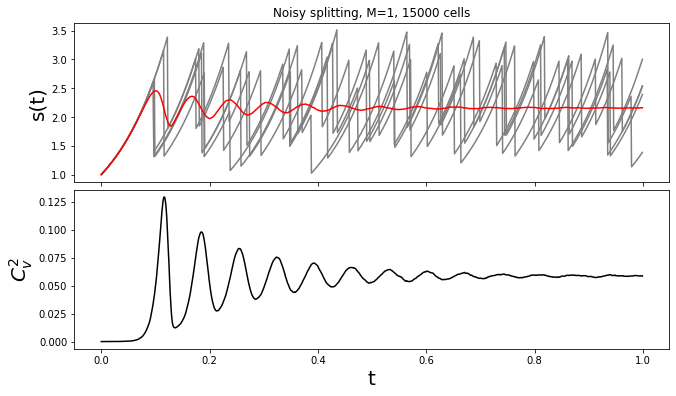

In [303]:
fig, ax = plt.subplots(nrows=2,figsize=(16/1.5,9/1.5),sharex=True)

plt.sca(ax[0])
plt.title(f"Noisy splitting, M=1, {Nsys} cells")
for i in range(5):
    sim = size_evaluate(*np.array([*division_evolve(t_max)]),ts)
    plt.plot(ts,sim,c='gray')

plt.plot(ts,means,c='r')
plt.ylabel("s(t)",fontsize=20)

plt.sca(ax[1])
plt.plot(ts,stds**2/means**2,c='k')
plt.ylabel(r"$C_v^2$",fontsize=20)

plt.subplots_adjust(hspace=0.05)
plt.xlabel("t",fontsize=20)
plt.savefig("oscillation.pdf")